In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import doctest
import copy

In [3]:
#https://stackoverflow.com/questions/40137950/possible-to-run-python-doctest-on-a-jupyter-cell-function
def test(func):
    '''
    Use test as a decorator to a function with doctests in Jupyter notebook. 
    Run the cell to see the results of the doctests.
    '''
    globs = copy.copy(globals())
    globs.update({func.__name__:func})
    doctest.run_docstring_examples(func, globs, verbose=True, name=func.__name__)
    return func

### Simulate straight line and circular movements with Bicycle model

Robot is at the origin (0, 0) and facing North, i.e, $\theta = \pi/2$. Assume the wheelbase of the vehicle $L$ = 0.9 m

In [5]:

#uncomment this decorator to test your code
@test 
def bicycle_model(curr_pose, v, delta, dt=1.0):
  '''
  >>> bicycle_model((0.0,0.0,0.0), 1.0, 0.0)
  (1.0, 0.0, 0.0)
  >>> bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
  (0.0, 0.0, 0.0)
  >>> bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
  (1.0, 0.0, 1.11)
  '''
  # write code to calculate next_pose
  # refer to the kinematic equations of a unicycle model
  L = 0.9
  x,y,theta = curr_pose
  x = x + v*np.cos(theta)*dt
  y = y + v*np.sin(theta)*dt
  theta = theta + round(v/L*np.tan(delta),2)*dt
    
  # Keep theta bounded between [-pi, pi]
  theta = np.arctan2(np.sin(theta), np.cos(theta))

  return (x, y, theta)
  #return 

Finding tests in bicycle_model
Trying:
    bicycle_model((0.0,0.0,0.0), 1.0, 0.0)
Expecting:
    (1.0, 0.0, 0.0)
ok
Trying:
    bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
Expecting:
    (0.0, 0.0, 0.0)
ok
Trying:
    bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
Expecting:
    (1.0, 0.0, 1.11)
ok


In [6]:
#straight line
straight_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
#fill in v and delta values
all_v = np.ones(steps)
all_delta = np.zeros(steps)
for v,delta in zip(all_v, all_delta):
   #instruction to take v, w and compute new pose    
    straight_trajectory.append(pose) 
    pose = bicycle_model(pose,v,delta)
   # store new pose
s_trajectory = np.array(straight_trajectory)  
print(s_trajectory)

    

[[0.00000000e+00 0.00000000e+00 1.57079633e+00]
 [6.12323400e-17 1.00000000e+00 1.57079633e+00]
 [1.22464680e-16 2.00000000e+00 1.57079633e+00]
 [1.83697020e-16 3.00000000e+00 1.57079633e+00]
 [2.44929360e-16 4.00000000e+00 1.57079633e+00]
 [3.06161700e-16 5.00000000e+00 1.57079633e+00]
 [3.67394040e-16 6.00000000e+00 1.57079633e+00]
 [4.28626380e-16 7.00000000e+00 1.57079633e+00]
 [4.89858720e-16 8.00000000e+00 1.57079633e+00]
 [5.51091060e-16 9.00000000e+00 1.57079633e+00]]


In [7]:
#circle
circle_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
#fill in v and omega values
all_v = np.ones(steps*100)
all_delta = np.ones(steps*100)
for v,delta in zip(all_v, all_delta):
    #instruction to take v, delta and compute new pose    
    circle_trajectory.append(pose) 
    pose = bicycle_model(pose,v,delta,0.1)
   # store new pose
circlular_trajectory = np.array(circle_trajectory)  
   # store new pose
print(circlular_trajectory)
   


[[ 0.00000000e+00  0.00000000e+00  1.57079633e+00]
 [ 6.12323400e-18  1.00000000e-01  1.74379633e+00]
 [-1.72138338e-02  1.98507279e-01  1.91679633e+00]
 ...
 [-1.11120531e+00  2.71692575e-01 -1.87739227e+00]
 [-1.14138682e+00  1.76355927e-01 -1.70439227e+00]
 [-1.15470671e+00  7.72469940e-02 -1.53139227e+00]]


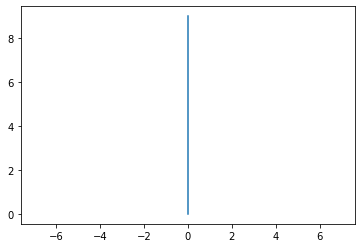

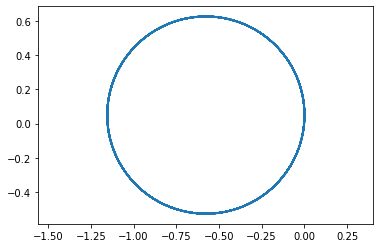

In [8]:
### Plot straight and circular trajectories
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(s_trajectory[:,0], s_trajectory[:,1])

plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(circlular_trajectory[:,0], circlular_trajectory[:,1])


### Simulate Bicycle model with Open Loop control

We want the robot to follow these instructions

**straight 10m, right turn, straight 5m, left turn, straight 8m, right turn**

It is in open loop; control commands have to be calculated upfront. How do we do it?

To keep things simple in the first iteration, we can fix $v = v_c$ and change only $\delta$. To make it even simpler, $\delta$ can take only 2 values 
+ 0 when the vehicle is going straight 
+ $\delta = \delta_c$ when turning

This leaves only 2 questions to be answered
* What should be $v_c$ and $\delta_c$?
* When should $\delta$ change from 0 and back?

In [9]:
v_c = 1 # m/s
delta_c = np.pi/6 # rad/s

#calculate time taken to finish a quarter turn (pi/2)
# unlike you would need to take into account v_c and L of the vehicle as well
t_turn = int(np.pi/2/delta_c)

#calculate the time taken to finish straight segments
# omega array is to be padded with equivalent zeros

t_straight1, t_straight2, t_straight3 = int(10/v_c), int(5/v_c), int(8/v_c)

all_delta = [0]*t_straight1 + [delta_c]*t_turn + \
        [0]*t_straight2 + [delta_c]*t_turn + \
        [0]*t_straight3 + [-delta_c]*t_turn
all_v = v_c*np.ones_like(all_delta)

Let us make a cool function out of this!

Take in as input a generic route and convert it into open-loop commands

Input format: [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]

Output: all_v, all_delta

In [10]:
def get_open_loop_commands(route, vc=1, deltac=np.pi/12):
    all_delta = []
    for dir, command in route: 
      if dir == 'straight':
        t_straight = np.ceil(command/vc).astype('int')
        all_delta += [0]*t_straight
      elif dir == 'right':
        all_delta += [-deltac]*np.ceil(np.deg2rad(command)/deltac).astype('int')
      else:
        all_delta += [deltac]*np.ceil(np.deg2rad(command)/deltac).astype('int')
    all_v = vc*np.ones_like(all_delta)
    print(len(all_delta))
    print(len(all_v))
    return all_v, all_delta

### Unit test your function with the following inputs

+ [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]
+ $v_c = 1$
+ $delta_c = \pi/12$

In [11]:
v, delta = get_open_loop_commands([("straight", 5), ("right", 90), ("straight", 6), ("left", 85)], 1, np.pi/12)

23
23


In [12]:
robot_trajectory = []
all_v, all_delta = get_open_loop_commands([("straight", 5), ("right", 90), ("straight", 6), ("left", 85)])
pose = np.array([0, 0, np.pi/2])
for v, delta in zip(all_v, all_delta):
    #instruction to take v, w and compute new pose    
    robot_trajectory.append(pose) 
    pose = bicycle_model(pose,v,delta)
   # store new pose
print(robot_trajectory)
print(len(robot_trajectory))
robot_trajectory = np.array(robot_trajectory)

23
23
[array([0.        , 0.        , 1.57079633]), (6.123233995736766e-17, 1.0, 1.5707963267948966), (1.2246467991473532e-16, 2.0, 1.5707963267948966), (1.8369701987210297e-16, 3.0, 1.5707963267948966), (2.4492935982947064e-16, 4.0, 1.5707963267948966), (3.061616997868383e-16, 5.0, 1.5707963267948966), (3.67394039744206e-16, 6.0, 1.2707963267948965), (0.29552020666134005, 6.955336489125606, 0.9707963267948965), (0.8601626800563755, 7.780672104035284, 0.6707963267948964), (1.643489589683859, 8.40228207230595, 0.37079632679489644), (2.5755286756510856, 8.764639826782624, 0.07079632679489645), (3.57302366225514, 8.835377028450326, -0.22920367320510354), (4.546871293133336, 8.608174933757239, -0.22920367320510354), (5.520718924011531, 8.380972839064151, -0.22920367320510354), (6.494566554889726, 8.153770744371064, -0.22920367320510354), (7.468414185767921, 7.926568649677977, -0.22920367320510354), (8.442261816646116, 7.6993665549848895, -0.22920367320510354), (9.416109447524311, 7.4721644

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


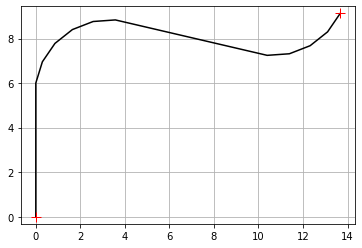

In [13]:
# plot robot trajectory
plt.figure()
plt.grid()
xi, yi, _ = robot_trajectory[0]
xf, yf, _ = robot_trajectory[-1]
plt.axes().set_aspect("equal","datalim")
plt.plot(robot_trajectory[:,0], robot_trajectory[:,1],'black')

#show first and last robot positions with + markers
plt.plot(xi, yi, 'r+', ms=10)
plt.plot(xf, yf, 'r+', ms=10)


### Shape the turn
Let us try something cooler than before (though a bit tricky in open loop). Instead of boring circular arcs, change the steering angle so that the robot orientation changes as shown in the equation below

$\theta = (\theta_i - \theta_f) * (1 - 3x^2 + 2\theta^3) + \theta_f  \thinspace \vee x \in [0,1]$

First let us plot this

In [14]:
def poly_turn(theta_i, theta_f, n=10):
    x = np.linspace(0, 1, num=n)
    return (theta_i-theta_f) * (1 - 3 * x * x + 2 * (x**3)) + theta_f

How does a right turn look? 

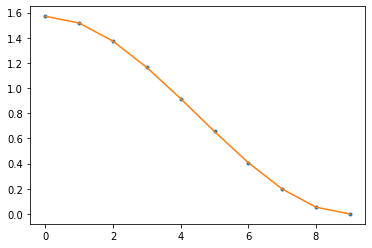

In [15]:
plt.figure()
plt.plot(poly_turn(np.pi/2, 0),'.')
plt.plot(poly_turn(np.pi/2, 0))


Now plot a right turn (North to East)

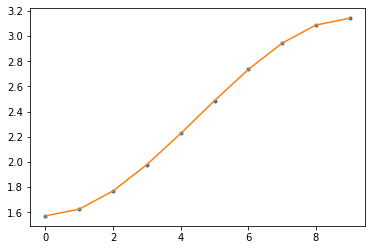

In [16]:
plt.figure()
plt.plot(poly_turn(np.pi/2, np.pi),'.')
plt.plot(poly_turn(np.pi/2, np.pi))

How does $\theta$ change when we had constant $\delta$? Plot it

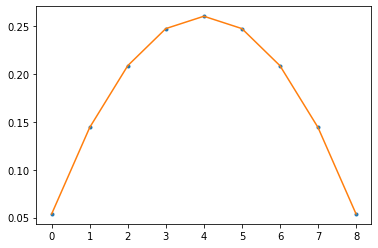

In [17]:
theta_change = np.diff(poly_turn(np.pi/2, np.pi))
plt.plot(theta_change,'.')
plt.plot(theta_change)

We know the rate of change of $\theta$ is proportional to $\delta$. Can you work out the sequence of $\delta$ to change $\theta$ as in the cubic polynomial shown above?

In [18]:
L = 0.9
v = 1
theta_change = np.diff(poly_turn(np.pi/2, np.pi))
delta = np.arctan((L/v)*theta_change)
print(delta)

[0.04844344 0.12920623 0.18593495 0.21942362 0.23048008 0.21942362
 0.18593495 0.12920623 0.04844344]
